In [19]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display








#
def planegauss(shape, w = 1/2, win=((-2, 2), (-2, 2))): # function to generate a gaussian across a 2d array, used for gaussian initial condition
    npx = np.linspace( win[0][0], win[0][1], shape[0] )
    npy = np.linspace( win[1][0],win[1][1], shape[1] )
    npxx, npyy = np.meshgrid(npx, npy)
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) / (w*w) )
    return (h)




def lingauss(shape, w = 1/2, ax = 0, win = (-2, 2)):
    npx = np.linspace( win[0], win[1], shape[0] )
    npy = np.linspace( win[0], win[1], shape[1] )
    npxx, npyy = np.meshgrid(npy, npx)
    xy = (npyy, npxx)[ax]
    h = np.exp( -np.e * ( xy*xy ) / (w*w) )
    return (h)





#

In [26]:
#


# useful math functions

def partial(a, dx, ax):
    partial = ( np.roll(a, -1, ax) - np.roll(a, 1, ax) )/(2*dx) # f(x+dx) - f(x) / dx
    return (partial)
def d_dx(a, dx):
    ddx = -partial(a, dx, 0)
#     ddx[0] = ddx[1] # first row is roll-over nonsense
#     ddx[-1] = ddx[-2] # last row rollover nonsense
    return ddx
def d_dy(a, dy):
    ddy = -partial(a, dy, 1)
#     ddy[:,0] = ddy[:,1] # first collumn is roll-over nonsense
#     ddy[:,-1] = ddy[:,-2] # last col roll over nonsense
    return ddy
def div(u, v, DX):
#     div = (np.roll(d_dx(u), 1, 0)+np.roll(d_dy(v), 1, 1)) # has asymetry wrong grid
    div = d_dy(v, DX[1]) + d_dx(u, DX[0])
    return div


#

In [20]:
#

class p():
    g = 10



        
        
class initcons():
#     def __init__(self):
    #self.
    DX = (100, 100) # meters
    size = (100, 100) # grid squares (dx)

    #initial condition constants
    #self.
    h = 1000#-300*planegauss(size, 1)+400
    n = 1*lingauss(size, 1/4, 0, (-4, 0)) # intial condition
    u = np.zeros(size) # global x vel array
    v = np.zeros(size) # global y vel array


# initcons = initcon()

class State():
    g = 10 # m/s/s
    def __init__(self, DX, h, n, u, v):
        
        self.DX = DX
        self.h = h
        
        self.wavespeed = np.sqrt(np.max(self.h)*p.g)
        
        self.n = n
        self.u = u # global x vel array
        self.v = v # global y vel array
        
        assert (np.isscalar(self.h) or self.h.shape == self.h.shape) # 'or' is short circuit
        self.calcDt()
        return
    
    def calcDt(self, fudge = 2):
        self.dt = np.min(self.DX)/(fudge*self.wavespeed)
        return
    def setnuv(self, n, u, v):
        self.n, self.u, self.v = n, u, v
        return


state1 = State(initcons.DX, initcons.h, initcons.n, initcons.u, initcons.v)
#

In [4]:
#


# display functions

def dispimg(a):
    imgplot = plt.imshow(a, 'Oranges')
    plt.colorbar()
    return

def disp3d(a, xlim='default', ylim='default', fsize = (10, 10), lines=(25,25)):
    if (xlim=='default'): xlim = (0, a.shape[0])
    if (ylim=='default'): ylim = (0, a.shape[1])
    
    x = np.linspace(0, a.shape[0]-1, lines[0], dtype=int)
    y = np.linspace(0, a.shape[1]-1, lines[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    aa = a[xx,yy]
    
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(xx, yy, aa)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    
    return

def vect(u, v, xlim='default', ylim='default', fsize=(10, 10), arws=(10, 10), arwsz=1):
    if (xlim=='default'): xlim = (0, u.shape[0])
    if (ylim=='default'): ylim = (0, v.shape[1])
    arws = (int(arws[0]), int(arws[1]))
    
    x = np.linspace(0, u.shape[0]-1, arws[0], dtype=int)
    y = np.linspace(0, v.shape[1]-1, arws[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    uu = u[x,y]
    vv = v[x,y]
    m = np.hypot(uu, vv)
    
    fig, ax = plt.subplots(figsize=fsize)
    ax.quiver(xx, yy, uu, vv, m, scale = 1/arwsz)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    
    return




    

#

surface height


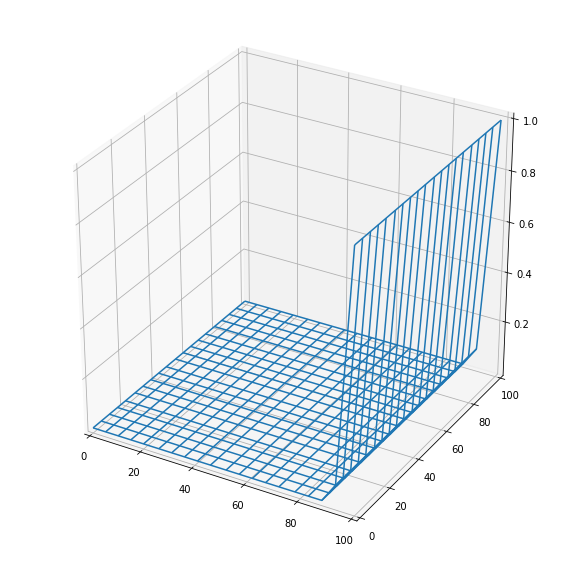

bathymetry
group velocity


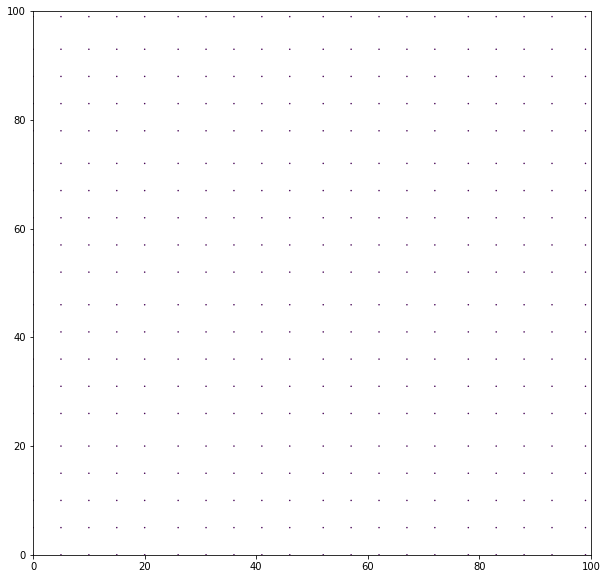

In [24]:
#


#display initial conditions, tests display functions
print("surface height")
disp3d(state1.n, lines=(20, 20))
print("bathymetry")
# disp3d(-state1.h, lines=(20, 20))
print("group velocity")
vect(state1.u, state1.v, arws=(20, 20))

#

In [6]:
#


def forward(h, n, u, v, dt, DX): # forward euler timestep
    nn1 = n - ( d_dx((h+n)*u, DX[0]) +  d_dy((h+n)*v, DX[1]) )*dt  #dn/dt = -div((n+h)u,(n+h)v])
    un1 = u - ( p.g*d_dx(n, DX[0]) )*dt  #                            du/dt = -g*dn/dx              u*d_dx(u)+v*d_dy(u)+
    vn1 = v - ( p.g*d_dy(n, DX[1]) )*dt  #                         dv/dt = -g*dn/dy
    return nn1, un1, vn1

def fbfeedback(hn, nn, un, vn, dt, DX): # forward backward feedback
    def dndt(u, v) : return ( -(div((hn+nn)*u,(hn+nn)*v, DX)) )
    def dudt(n) : return ( -p.g*d_dx(n, DX[0]) )
    def dvdt(n) : return ( -p.g*d_dy(n, DX[1]) )
    beta = 1/3
    eps = 2/3
    
    nn1g = nn + dndt(un, vn)*dt
    un1g = un + ( beta*dudt(nn1g) +  (1-beta)*dudt(nn) )*dt
    vn1g = vn + ( beta*dvdt(nn1g) +  (1-beta)*dvdt(nn) )*dt
    
    nn1 = nn + 0.5*(dndt(un1g, vn1g) + dndt(un, vn))*dt
    un1 = un + 0.5*(eps*dudt(nn1)+(1-eps)*dudt(nn1g)+dudt(nn))*dt
    vn1 = vn + 0.5*(eps*dvdt(nn1)+(1-eps)*dvdt(nn1g)+dvdt(nn))*dt
    
    return nn1, un1, vn1

timestep = fbfeedback

#

In [7]:
#



# simulate through time


# displays resulting water height after time t
def _simulate(h, n, u, v, t, DX, dt = 1):
    # dont try if timstep is zero or negative
    if (dt <= 0):
        return False
    
    # iterate t times with interval size dt
    itr = 0
    while (itr < t):
        n, u, v = timestep(h, n, u, v, dt, DX) # pushes n, u, v one step into the future
        itr += dt
    
    return n, u ,v


def simulate(state, t):
    endState = State(state.DX, state.h, state.n, state.u, state.v)
    endState.n, endState.u, endState.v = _simulate(state.h, state.n, state.u, state.v, t, state.DX, state.dt)
#     state.setnuv(n, u, v)
    return endState
    
#

In [8]:
#
 
# runs and displays simulation
def rendersim(state, t):
    
    
#     nextstate = State(state.DX, state.h, state.n, state.u, state.v)
    
    # run simulation with initial condition inputs and t seconds
    endstate = simulate(state, t)
#     state.setnuv(endState.n, endState.u, endState.v)
    
    print('integral dxdy: ')
    print(np.sum(endstate.n))
    print('total divergence: ')
    print(np.sum(div(endstate.u, endstate.v, endstate.DX)))
    
    # display water height
    disp3d(endstate.n)
    
    # display vector feild of velocity
    vect(endstate.u, endstate.v, arws = (30, 30), arwsz=0.1)
    
    return

#

In [27]:
#
def renderstate1(t): rendersim(state1, t)

# control and interact with sim
controls = interactive(renderstate1, # runs simulate() on initial conditions
                       {'manual' : True, 'manual_name' : 'run simulation'}, # dont run until I say so
                       t = widgets.IntSlider(min = 0, max = 500, value = 0) # time elapsed
                       )
display(controls)
#                        dt = widgets.FloatSlider(min = 0.25*DT, max = 4*DT, step = 0.1*DT, value = DT) # time interval

#                       state = state1,
#

interactive(children=(IntSlider(value=0, description='t', max=500), Button(description='run simulation', style…

In [10]:
#wavespeed test
import unittest




class testWaveSpeed(unittest.TestCase):
    def setUp(self):
        self.dur = 100 # duration of period to calculate speed over
        self.DX = (100, 100) # meters
        self.size = (10, 1000) # grid squares (dx's)
        self.h = 10#*planegauss((sizex, sizey), 1)
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition
        self.u = np.zeros(self.size) # global x vel array
        self.v = np.zeros(self.size) # global y vel array
    def calcWaveSpeed(self, ar1, ar2, Dt):
        midstrip1 = ar1[:,:int(ar1.shape[1]/2)]
        midstrip2 = ar2[:,:int(ar2.shape[1]/2)]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        speed = (peakloc2 - peakloc2)/Dt
        return speed
    def calcExactWaveSpeed(self):
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self):
        self.testStart = State(self.DX, self.h, self.n, self.u, self.v)
        self.testEnd = simulate(self.testStart, self.dur)
        
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEnd.n, self.dur )
        exactws = self.calcExactWaveSpeed()
        
        err = calcedws - exactws
        assert(abs(err) < 11)
    def tearDown(self):
        del(self.dur)
        del(self.DX)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)



unittest.main(argv=['first-arg-is-ignored'], exit=False)




.
----------------------------------------------------------------------
Ran 1 test in 0.100s

OK


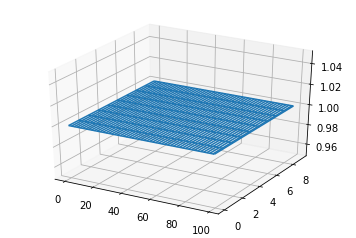

In [11]:
a = np.arange(100)
b = np.arange(10)
aa, bb = np.meshgrid(a, b)
aa.shape, bb.shape
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(aa, bb, np.ones((10, 100)))

In [12]:
import unittest

# unit test of differential functions
class testdifferential(unittest.TestCase):
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # 2d array
        self.ddthreshold = 1E-16
        
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)
        
        
unittest.main(argv=['first-arg-is-ignored'], exit=False)

#You can pass further arguments in the argv list, e.g.

#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

..
----------------------------------------------------------------------
Ran 2 tests in 0.109s

OK


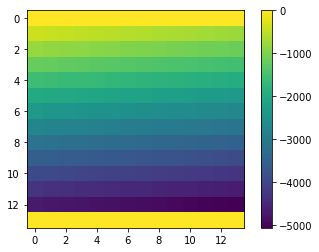

In [13]:
b = np.arange(196)
b = b.reshape(14, 14)
b = b*b #x^2 array

fig, ax = plt.subplots()
adif = plt.imshow(d_dx(b, 1)) # should print a constange in x with odd boundaries
plt.colorbar()